# ICON-LES

## Setup

These ICON Large-eddy simulations (LES) presented here consist of three different domains that have different spatial and temporal extends depending on their horizontal grid-spacing. {numref}`icon_domains` shows the extend of the different simulations.

```{figure} figures/icon_les_domains.jpg
:name: icon_domains
:alt: ICON-LES domain overview
:width: 800px
:align: center

Overview of simulation domains. The location of the Barbados Cloud Observatory (BCO) and the NTAS buoy are marked with a red star at the western and eastern part of the domain, respectively. For a sense of scale, the MODIS image of February 12 is shown with landmasses colored in green to brown depending on height. Satellite image source: NASA Worldview.
```

{numref}`icon_domains` illustrates further the extend of the ICON Storm-resolving simulation (SRM) that provides the boundary conditions for the ICON-624m run. ICON-312m and ICON-156m are both one-way nested in the respective coarser resolution run.

## Availability of simulation output

```{note}
Please note that this section is still under development and might change. Please revisit this page regularly for updates or changes.
```

In [1]:
import numpy as np
import datetime as dt
import dask
import matplotlib.pyplot as plt
import eurec4a
from zarr.errors import PathNotFoundError
from matplotlib import dates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use(["./mplstyle/book", "./mplstyle/wide"])
cat = eurec4a.get_intake_catalog()

In [2]:
def get_datasets(cat, datasets=None, path=""):
    """
    Recursively finding datasets in the given catalog.
    """
    if datasets is None:
        datasets = []
    for child in list(cat):
        desc = cat[child].describe()
        if desc["container"] == "catalog":
            if path != "":
                reference = ".".join(path, child)
            else:
                reference = child
            datasets.extend(get_datasets(cat[child], path=reference))
        else:
            datasets.extend([path + "." + desc["name"]])
    return datasets

def drop_datasets(datasets):
    """
    Drop datasets with same temporal coverage to
    ease computation and declutter the overview page.
    """
    datasets_to_keep = []
    for dataset in datasets:
        if ('meteogram' in dataset) and ('BCO' not in dataset):
            continue
        elif ('synthetic_radar' in dataset) and ('BCO' not in dataset):
            continue
        else:
            datasets_to_keep.append(dataset)
    return datasets_to_keep

icon_les_cat = cat.simulations.ICON
datasets = drop_datasets(get_datasets(icon_les_cat))

The currently available ICON-LES output is shown in the following:

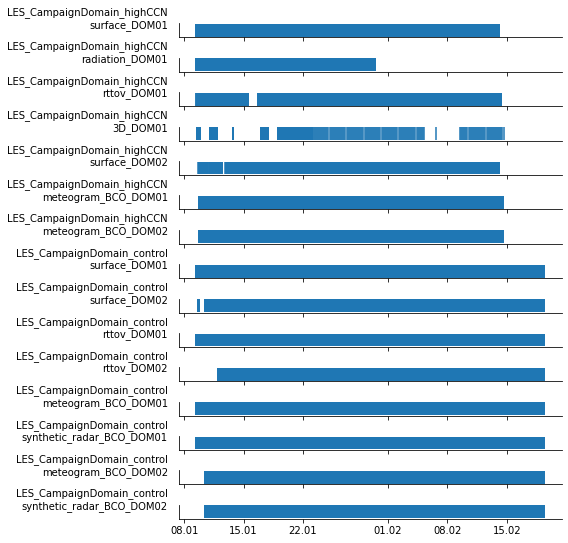

In [3]:
fig_height = len(datasets) * 0.5
fig, axs = plt.subplots(len(datasets), 1, figsize=(8, fig_height), sharex=True)
fig.set_constrained_layout(False)
xfmt = dates.DateFormatter('%d.%m')
for d, dataset in enumerate(datasets):
    # Load dataset
    try:
        ds = icon_les_cat[dataset].to_dask()
        axs[d].vlines(ds.time.values, 0, 1)
    except (FileNotFoundError, PathNotFoundError):
        pass
    axs[d].set_aspect(1.5)
    axs[d].set_ylabel(dataset.replace(".","\n"), rotation=0, ha='right')
    axs[d].set(yticklabels=[])  # remove the tick labels
    axs[d].tick_params(left=False)  # remove the ticks
axs[d].xaxis.set_major_formatter(xfmt)
plt.tight_layout()

## Output description

There are two main experiments: `LES_CampaignDomain_control` and `LES_CampaignDomain_highCCN`. These experiments only distinguish themselves by the prescribed cloud condensation nuclei (CCN) concentration, respectively 1700 cm$^{-3}$ and 130 cm$^{-3}$. `DOM01` refers to the 624m run, while `DOM02` refers to the 312m nest. As the variable names suggest, the `surface` entries contain the surface variables. `rttov` refers to forward simulated synthetic satellite images and meteogram output is available at different locations using the entry format `meteogram_<location>_<domain>`. The 2D and 3D radiation fields and fluxes are referenced with `radiation`.

## Visualization

The simulation output is mostly available on its natural, icosahedral grid but some output, like the rttov brightness temperatures, have been regridded onto a regular lat-lon grid. The following section shows how these different outputs can be visualized and explored.

### Regular grid

#### Loading modules

In [4]:
import eurec4a
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import datashader
from datashader.mpl_ext import dsshow

import cartopy.crs as ccrs
import cartopy.feature as cf

#### Selecting output
The simulation output is indexed in the EUREC<sup>4</sup>A Intake catalog and can be easily queried:

In [5]:
cat = eurec4a.get_intake_catalog()

# Lazy loading of selected output
data = cat.simulations.ICON.LES_CampaignDomain_control.rttov_DOM01.to_dask()
print(data)
variable = "synsat_rttov_forward_model_1__abi_ir__goes_16__channel_7"  #choose one of the once below
da = data[variable].sel(time='2020-02-08 12:00:00')

<xarray.Dataset>
Dimensions:                                                   (lat: 760,
                                                               lon: 1220,
                                                               time: 5903)
Coordinates:
  * lat                                                       (lat) float64 7...
  * lon                                                       (lon) float64 -...
  * time                                                      (time) datetime64[ns] ...
Data variables:
    synsat_rttov_forward_model_1__abi_ir__goes_16__channel_1  (time, lat, lon) float32 dask.array<chunksize=(12, 760, 1220), meta=np.ndarray>
    synsat_rttov_forward_model_1__abi_ir__goes_16__channel_2  (time, lat, lon) float32 dask.array<chunksize=(12, 760, 1220), meta=np.ndarray>
    synsat_rttov_forward_model_1__abi_ir__goes_16__channel_3  (time, lat, lon) float32 dask.array<chunksize=(12, 760, 1220), meta=np.ndarray>
    synsat_rttov_forward_model_1__abi_ir__goes_16__chann

#### Setting the scene

In [6]:
central_longitude = -53.54884554550185
central_latitude = 12.28815437976341
satellite_height = 8225469.943160511

vmin = 270
vmax = 300
cmap = "RdBu_r"

#### Projection and plotting

The regular grid data can also be plotted with a simple `da.plot()`, but more steps are involved for projections and some tweeks for faster plotting
that come especially handy for the plotting of data on the icosahedral grid shown in the next section.

/usr/share/miniconda/envs/how_to_eurec4a/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


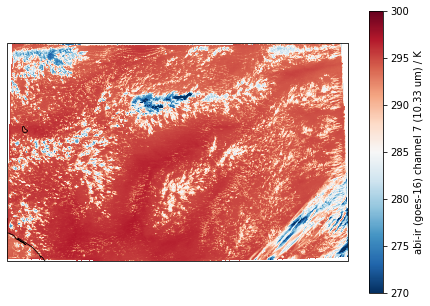

In [7]:
projection = ccrs.NearsidePerspective(central_longitude=central_longitude, central_latitude=central_latitude, satellite_height=satellite_height)

lats, lons = np.meshgrid(data.lat,data.lon)
coords = projection.transform_points(
    ccrs.Geodetic(),
    lons.T.flatten(),
    lats.T.flatten(),
)

fig, ax = plt.subplots(subplot_kw={"projection": projection})
fig.canvas.draw_idle()
ax.add_feature(cf.COASTLINE, linewidth=0.8)

artist = dsshow(
    pd.DataFrame({
        "val": da.values.flatten(),
        "x": coords[:, 0],
        "y": coords[:, 1],
    }),
    datashader.Point('x', 'y'),
    datashader.mean('val'),
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
    ax=ax,
)

fig.colorbar(artist, label=f"{da.long_name} / {da.units}");

### Icosahedral grid

For the visualization of the icosahedral grid, and interactive version exists that relies on [gridlook](https://gitlab.gwdg.de/tobi/gridlook) and is shown below
for the surface values of *LES_CampaignDomain_control* and *DOM01*. Try it out!

In [8]:
from IPython.display import IFrame, display
display(IFrame('https://tobi.pages.gwdg.de/gridlook/#https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/EUREC4A_LES/json_eurec4a_sim_time.json', '100%', '600px'))

Static views can be exported within the app and plotted separatedly. Here is an example for the 2m temperature that build on top of the plotting routine of the regular grid.

/usr/share/miniconda/envs/how_to_eurec4a/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


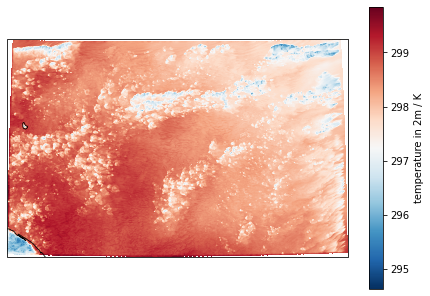

In [9]:
# Lazy loading of output and grid
data = cat.simulations.ICON.LES_CampaignDomain_control.surface_DOM01.to_dask()
grid = cat.simulations.grids[data.uuidOfHGrid].to_dask()

central_longitude = -53.54884554550185
central_latitude = 12.28815437976341
satellite_height = 8225469.943160511

vmin = 294.6328125
vmax = 299.84375
cmap = "RdBu_r"
variable = "t_2m"

da = data[variable].sel(time='2020-02-08 12:00:00')

projection = ccrs.NearsidePerspective(central_longitude=central_longitude, central_latitude=central_latitude, satellite_height=satellite_height)

coords = projection.transform_points(
    ccrs.Geodetic(),
    np.rad2deg(grid.clon.values),
    np.rad2deg(grid.clat.values),
)

fig, ax = plt.subplots(subplot_kw={"projection": projection})
fig.canvas.draw_idle()
ax.add_feature(cf.COASTLINE, linewidth=0.8)

artist = dsshow(
    pd.DataFrame({
        "val": da.values,
        "x": coords[:, 0],
        "y": coords[:, 1],
    }),
    datashader.Point('x', 'y'),
    datashader.mean('val'),
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
    ax=ax,
)

fig.colorbar(artist, label=f"{da.long_name} / {da.units}");

## Questions and further information

Questions and issues with this dataset should be raised at the [GITLAB-Repository](https://gitlab.gwdg.de/hauke.schulz/EUREC4A-ICON) to encourage an open discussion and share experiences. The repository is also the place where further information about these simulations can be found.